# MD Online Analysis Template
---

This notebook aims to propose a template for MD online monitoring and postprocessing of the taken data. This notebook shall be used with the cl2pd package, as suggested in the header. 

Help improving or reporting bugs: axel.poyet@cern.ch and guido.sterbini@cern.ch

In [1]:
from cl2pd import importData
from cl2pd import plotFunctions
from cl2pd import dotdict
from cl2pd import MDanalysis
from cl2pd import variablesDF

dotdict=dotdict.dotdict
pd=importData.pd     # is the pandas package
np=importData.np     # is the numpy package
cals=importData.cals # pytimber log class

import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display
mySource='/eos/user/a/apoyet/SWAN_projects/2018/md2pd/MD_template_new.ipynb'

# Functions section
---

Here are all the function that, after discussion, will be pushed in a package, or will live inside this notebook. 

In [4]:
def getFillingPattern(FBCT_B1,FBCT_B2):
    '''
    From pandas series FBCT_BX, return a dotdict containing the present filling scheme in the machine. 
    '''
    fillB1 = np.where(FBCT_B1.dropna().iloc[0])[0]
    fillB2 = np.where(FBCT_B2.dropna().iloc[0])[0]
    return dotdict({'atB1':fillB1,'atB2':fillB2})

In [5]:
def postProcess(DF,FILL_PATTERN,sample_sec=90):
    myData = dotdict({})
    LUMI_ATLAS = MDanalysis.list2col(DF['ATLAS:BUNCH_LUMI_INST'],fill=np.concatenate([FILL_PATTERN.atB1,FILL_PATTERN.atB2]))
    LUMI_CMS = MDanalysis.list2col(DF['CMS:BUNCH_LUMI_INST'],fill=np.concatenate([FILL_PATTERN.atB1,FILL_PATTERN.atB2]))*1e3 

    for beam in ['atB1','atB2']:
        myTmp = dotdict({})
        FBCT = MDanalysis.list2col(DF['LHC.BCTFR.A6R4.'+beam[2:]+':BUNCH_INTENSITY'],fill=FILL_PATTERN[beam])
        for bunch in FILL_PATTERN[beam]:
            myDF = pd.DataFrame()
            myDF['Diff_Intensity'] = FBCT[bunch].resample(str(sample_sec)+'s').mean().diff()/float(sample_sec)
            myDF['Lumi_ATLAS'] = LUMI_ATLAS[bunch].resample(str(sample_sec)+'s').mean()
            myDF['Lumi_CMS'] = LUMI_CMS[bunch].resample(str(sample_sec)+'s').mean()
            totLumi_mb = (myDF['Lumi_ATLAS'].values+myDF['Lumi_CMS'].values)
            dI_dt = myDF['Diff_Intensity'].values
            myDF['Eff_section_mb'] = -dI_dt/totLumi_mb
            #myDF = myDF.interpolate(method='linear')
            #I put thsi line in comment, in case
            myTmp.update({'at_b'+str(bunch):myDF})
        myData.update({beam:myTmp})
    return myData

In [6]:
def concatDotdict(myData,myData_new):
    myDict = dotdict({})
    for beam in ['atB1','atB2']:
        myTmp = dotdict({})
        for bunch in myData[beam].keys():
            myDF = pd.concat([myData[beam][bunch],myData_new[beam][bunch]])
            myTmp.update({bunch:myDF})
        myDict.update({beam:myTmp})
    return myDict

# Step 1: first download of data
---

At this stage, you will download a first amount of data, let's say 10 minutes, for the variables of your choice. In our case, we need the bunch-by-bunch intensity and luminosity from ATLAS and CMS

In [2]:
# Defintion of the variables

FBCT_VAR = list(variablesDF.LHC[(variablesDF.LHC['Description'].str.contains('Main FBCT')) & (variablesDF.LHC['Tag']=='Intensity')]['Variable'])
LUMI_VAR = list(variablesDF.LHC[variablesDF.LHC['Tag']=='Luminosity']['Variable'])
CURRENT_VAR = list(variablesDF.LHC[variablesDF.LHC['Description']=='Wire current']['Variable'])
VAR = FBCT_VAR+LUMI_VAR+CURRENT_VAR

In [3]:
# Time stamps

#T_NOW = pd.Timestamp.now(tz = TZ_GVA) #to work online
T_NOW = pd.Timestamp('2017-11-29 22:00',tz = 'CET') #to work in MD4 2017
DELTA_T_min = 10. # number of initial minutes
T_INIT = T_NOW - pd.Timedelta(str(DELTA_T_min)+'m')

RAW_DATA = importData.cals2pd(VAR,T_INIT,T_NOW)

# Step 2: Organize and post process the data
---

One wants to organise the data in a dotdict with the following structure: myData.BEAM.BUNCH. The leave of this tree is a pandas DF containing resampled data for intensity and the luminosity, but also our final observable here: the effective cross-section. 

In [7]:
# Filling scheme definition
# Please note that this tool is not meant to be used for operational filling schemes

FILL_PATTERN = getFillingPattern(RAW_DATA['LHC.BCTFR.A6R4.B1:BUNCH_INTENSITY'],RAW_DATA['LHC.BCTFR.A6R4.B2:BUNCH_INTENSITY'])

print('==== FILLING PATTERN B1 ====')
print(FILL_PATTERN.atB1)
print('==== FILLING PATTERN B2 ====')
print(FILL_PATTERN.atB2)


==== FILLING PATTERN B1 ====
[ 10 100 101 102 103 104 105 106 107 108 109 110 111 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403 404 405 406 407 408 409 410 411 412 413]
==== FILLING PATTERN B2 ====
[ 10 390]


In [8]:
# Post process and dotdict

myData = postProcess(RAW_DATA,FILL_PATTERN,sample_sec=90)

# Step 3: re-download, re-post process
---

Being an online monitoring, one has now to download live data, to add them to the raw_data DF, to post process it, and to add them to the tree. 

In [27]:
# Time definition

T1 = RAW_DATA.index[-1] # we start where we stopped
T2 = pd.Timestamp.now(tz='CET') # up to now! 
if 1: # Or if u prefer to use a given time interval, just replace the 0 by 1 :) 
    DELTA_T = 10.
    T2 = T1 + pd.Timedelta(str(DELTA_T)+'m')

# Dowload the new DF

NEW_DATA = importData.cals2pd(VAR,T1,T2)

# Add it to the main DF

RAW_DATA=pd.concat([RAW_DATA,NEW_DATA])

# Post process/concat

myData_new = postProcess(NEW_DATA,FILL_PATTERN,sample_sec=90)
myData = concatDotdict(myData,myData_new)


# Step 4: LET'S PLOT :) 

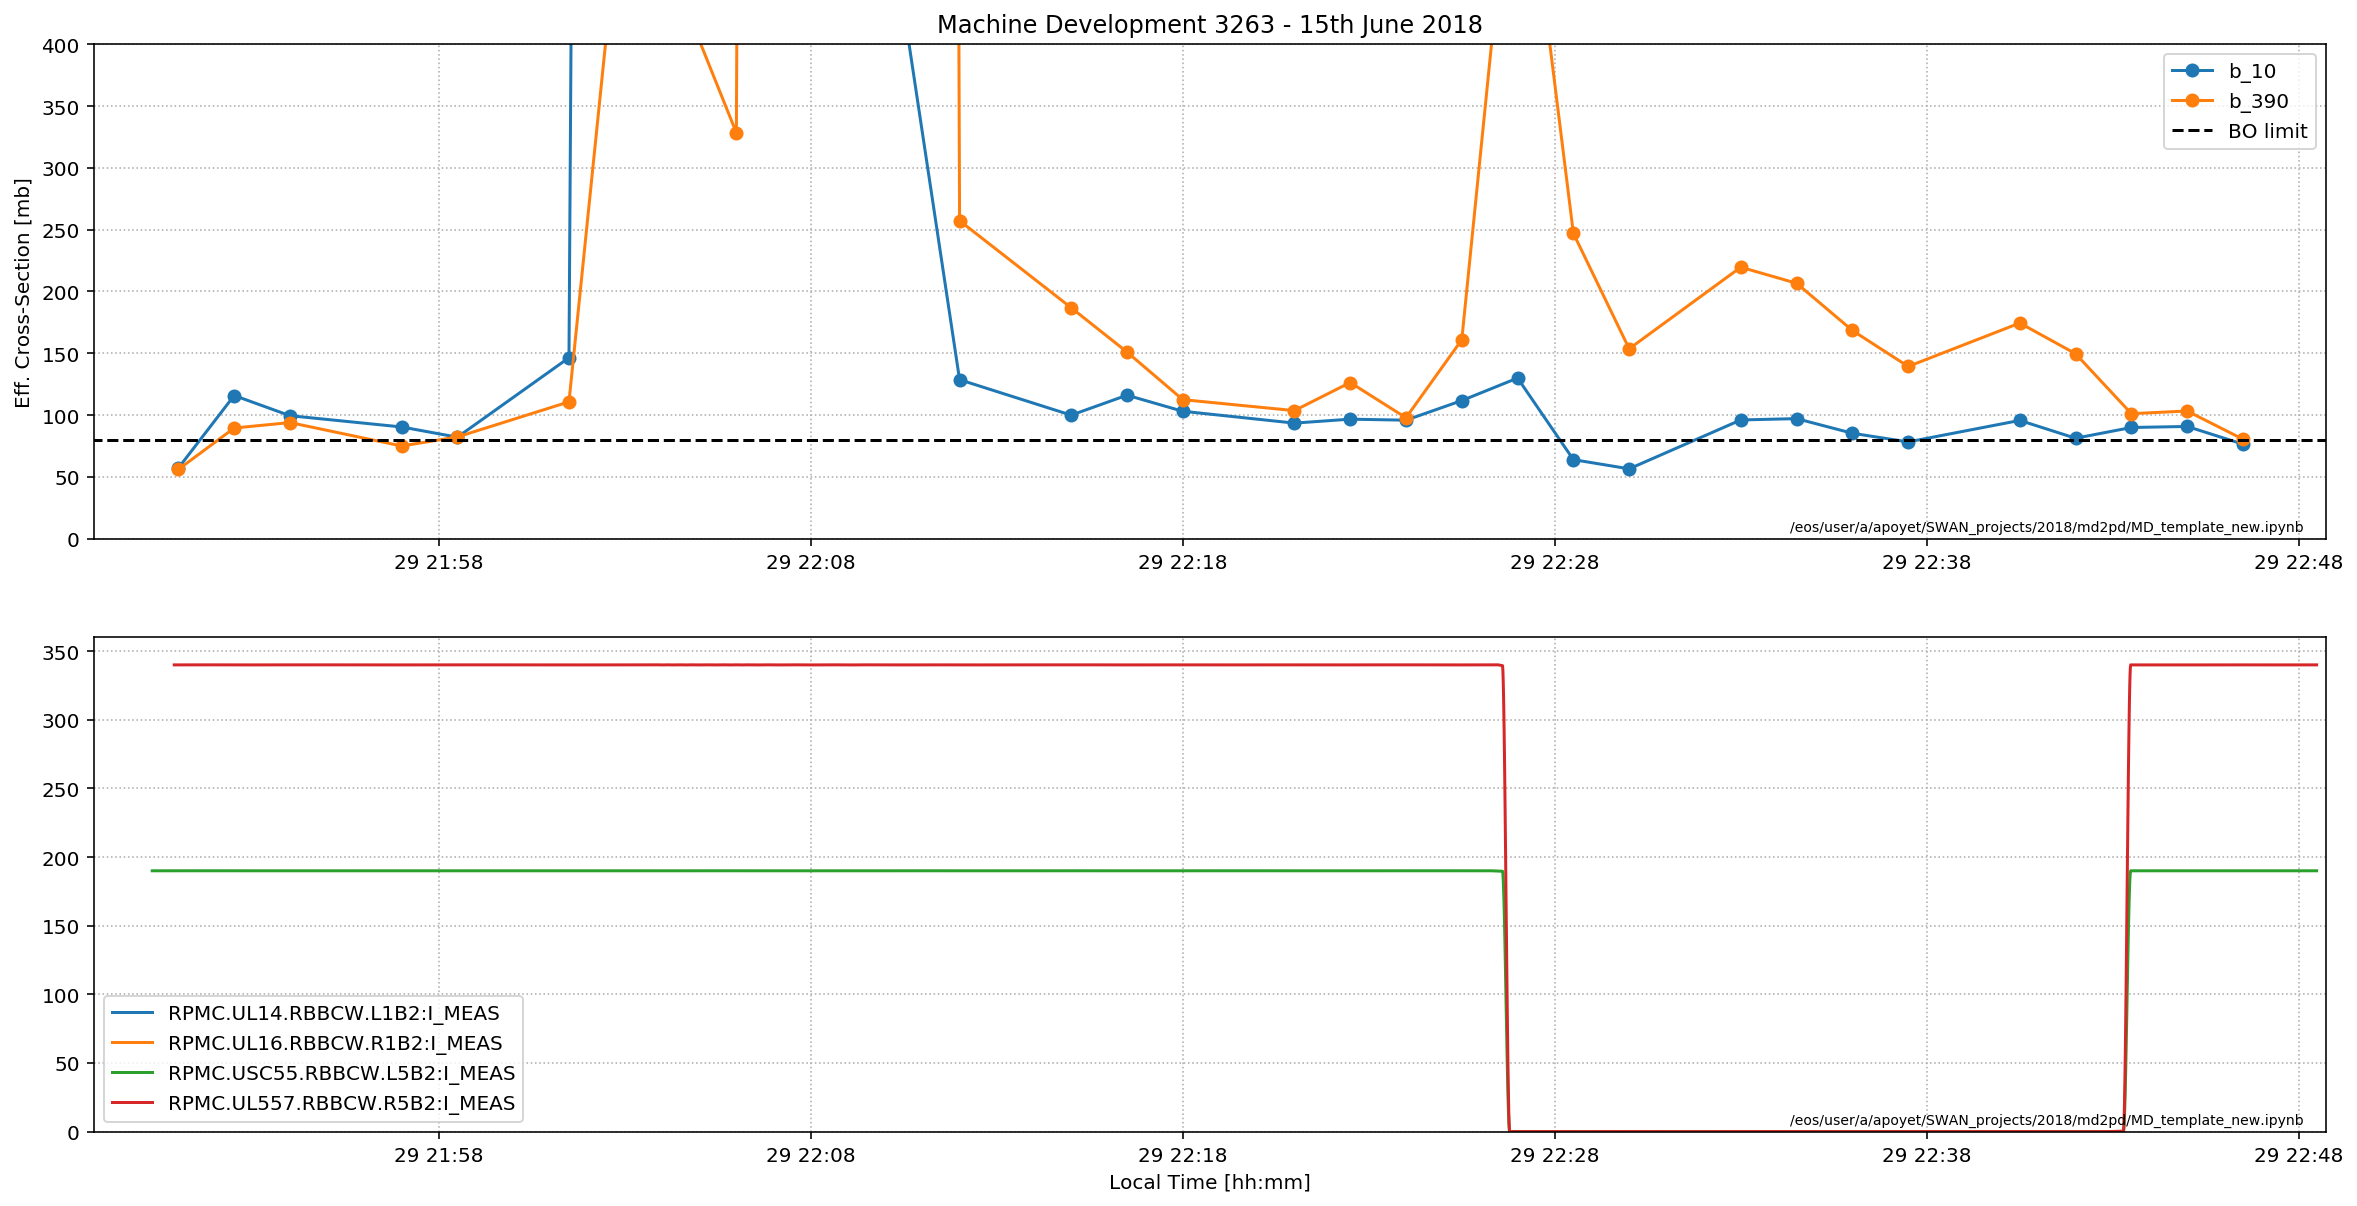

In [28]:
# We want to plot B2 

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
for i in FILL_PATTERN.atB2:
    x=myData.atB2['at_b'+str(i)]['Eff_section_mb'].dropna().index.tz_convert('CET')
    y=myData.atB2['at_b'+str(i)]['Eff_section_mb'].dropna().values
    plt.plot(x,y,'o-',label='b_'+str(i))
ax1.set_ylim(0,400)
plt.grid(ls=':')

plt.title('Machine Development 3263 - 15th June 2018')
ax1.set_ylabel('Eff. Cross-Section [mb]')
plt.plot(plt.xlim(),[80,80],'--k',label='BO limit')
plt.legend(loc='best',frameon=True)
plotFunctions.setSourcePlot(plt.gca(),mySource,color='k')

ax2 = fig.add_subplot(212, sharex=ax1)
aux = RAW_DATA[CURRENT_VAR]
for i in aux.columns:
    x = aux[i].dropna().index.tz_convert('CET')
    y = aux[i].dropna().values
    ax2.plot(x,y,label=i)
ax2.set_xlabel('Wire Current [A]')
ax2.set_ylim([0,360])
plotFunctions.setSourcePlot(plt.gca(),mySource,color='k')
plt.legend(loc='best',frameon=True)
plt.grid(ls=':')
plt.xlim(pd.Timestamp(RAW_DATA.index[-1] - pd.Timedelta('1H'),tz='CET').to_pydatetime(),pd.Timestamp(RAW_DATA.index[-1],tz='CET').to_pydatetime())
plt.xlabel('Local Time [hh:mm]');